#Notebook: Extract Features lables data
##Author: Lucía Núñez Calvo
###Date: 28/04/2024

####Summary

This notebook is used to extract the characteristics of the dataset provided by the Hospital Universitario de Burgos (**HUBU**).

As these are sensitive data that cannot be publicly exposed, this notebook will store the results obtained from the extraction of characteristics and will show three different types of visualisations.

Firstly, it should be noted that only the characteristics of the data stored in the *‘Unclassified’* directory will be extracted. The labels of these audio files can be found in the file ‘*Unclassified_data.csv*’. This action is done in order to have a double validation on the models. For this purpose, a total of five videos have been reserved and subsequently used to check the classifications performed by each of the models.

Secondly, in this notebook, two different feature extractions are observed, on the one hand the Mel Frequency Ceptral Coefficients (**MFCC**), and on the other hand, the Linear Predictive Coding (**LPC**). The obtained features and labels, have been stored in files with ‘.npy’ extension for later use in the models.

Finally, for each feature extraction, three different representations have been created, Principal Component Analysis (**PCA**), Distributed Stochastic Neighbor Embedding (**t-SNE**), and Uniform Manifold Approximation and Projection (**UMAP**).



####Structure of the notebook

0.   Installations
1.   Upload labelled data
2.   Definition of functions to represent features
3.   Extract MFCC features
4.   Plot MFCC features
5.   Extract LPC features
6.   Plot LPC features

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
import os
import ast  # Convert strings to lists
import umap
import joblib
import librosa
import numpy as np
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.signal.windows import get_window
from scipy.linalg import toeplitz, solve_toeplitz, LinAlgError

## 0. Installations

In [2]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.9 MB/s eta 0:00:00


## 1. Upload labelled data

In [4]:
unclassified_data = pd.read_csv('Unclassified_data.csv')
unclassified_data.head()

,File_name,Labels
0,Unclassified/39ae6684-c030-4008-ba0c-05551075d...,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Unclassified/47f38257-5a56-4814-b569-54d1c2177...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,Unclassified/0c84b92c-9996-4970-bece-10680196d...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,Unclassified/0887b999-d13d-4234-b8ef-c28e93977...,"[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, ..."
4,Unclassified/1181fa2b-8916-45d7-8009-ab2784701...,"[1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, ..."


In [5]:
#Definition of binary labels indicating whether the baby cries or does not cry
class_labels = {'Crying_baby': 0, 'NO_crying_baby': 1}

## 2. Definition of functions to represent features

In [13]:
def display_PCA(feature, labels, title):
  '''
  This function creates a visualisation of the data using the PCA method.

  Input:
    - feature: (array) matrix of features, each row representing a sample and each column a feature.
    - labels: (array) vector of labels corresponding to each sample.
    - title: (str) title of the graph.

  Output:
    - Scatter plot (2D) showing the characteristics in the PCA format.

  '''
  pca = PCA(n_components=2)
  feature_pca = pca.fit_transform(feature)

  plt.figure(figsize=(10, 8))
  scatter = plt.scatter(feature_pca[:, 0], feature_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)

  plt.title(title)
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')

  # Add a legend with the keys and names of the classes
  cbar = plt.colorbar(scatter, ticks=range(len(class_labels)), label='Class Labels')
  # Include the numerical index and the class name
  cbar.set_ticklabels([f"{v}-{k}" for k, v in class_labels.items()])

  plt.grid(True)
  plt.show()


def display_tSNE(feature, labels, title):
  '''
  This function creates a visualisation of the data using the t-SNE method.

  Input:
    - feature: (array) matrix of features, each row representing a sample and each column a feature.
    - labels: (array) vector of labels corresponding to each sample.
    - title: (str) title of the graph.

  Output:
    - Scatter plot (2D) showing the characteristics in the t-SNE format.
  '''
  # Invert dictionary to map tag numbers to names
  label_names = {v: k for k, v in class_labels.items()}

  tsne = TSNE(n_components=2, random_state=42)
  feature_tsne = tsne.fit_transform(feature)

  plt.figure(figsize=(10, 8))
  scatter_tsne = plt.scatter(feature_tsne[:, 0], feature_tsne[:, 1], c=labels, cmap='viridis', alpha=0.6)
  plt.title(title)
  plt.xlabel('t-SNE Component 1')
  plt.ylabel('t-SNE Component 2')

  # Add a legend with the keys and names of the classes
  cbar = plt.colorbar(scatter_tsne, ticks=range(len(class_labels)), label='Class Labels')
  # Include the numerical index and the class name
  cbar.set_ticklabels([f"{i}-{label_names[i]}" for i in range(len(class_labels))])

  plt.grid(True)
  plt.show()


def display_UMAP(feature, labels, title):
  '''
  This function creates a visualisation of the data using the UMAP method.

  Input:
    - feature: (array) matrix of features, each row representing a sample and each column a feature.
    - labels: (array) vector of labels corresponding to each sample.
    - title: (str) title of the graph.

  Output:
    - Scatter plot (2D) showing the characteristics in the UMAP format.
  '''
  # Invert dictionary to map tag numbers to names
  label_names = {v: k for k, v in class_labels.items()}

  umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, n_jobs=1, random_state=42)
  feature_umap = umap_reducer.fit_transform(feature)

  plt.figure(figsize=(10, 8))
  scatter_umap = plt.scatter(feature_umap[:, 0], feature_umap[:, 1], c=labels, cmap='viridis', alpha=0.6)
  plt.title(title)
  plt.xlabel('UMAP Component 1')
  plt.ylabel('UMAP Component 2')

  # Add a legend with the keys and names of the classes
  cbar = plt.colorbar(scatter_umap, ticks=range(len(class_labels)), label='Class Labels')
  # Include the numerical index and the class name
  cbar.set_ticklabels([f"{i}-{label_names[i]}" for i in range(len(class_labels))])

  plt.grid(True)
  plt.show()

## 3. Extract MFCC features

In [7]:
def extract_mfcc_features_per_second(file_name, n_mfcc=13, sr=44100):
    '''
    Extracts MFCC features for every second of an audio file.

    Input:
      - file_name: (str) Name of the audio file.
      - n_mfcc: (int) Number of MFCC coefficients to extract (default: 13).
      - sr: (int) Audio sampling rate (default: 44100 Hz).

    Output:
      - mfcc_list (list): List of MFCC features per second.

    '''
    try:
        # Load the audio file and its sample rate
        audio, sample_rate = librosa.load(file_name, sr=sr)
        mfcc_list = []
        buffer_length = sample_rate

        # Iterate over the audio in 1-second segments
        for i in range(0, len(audio), buffer_length):
            end_i = min(i + buffer_length, len(audio))
            audio_segment = audio[i:end_i]

            # Make sure that the segment is of sufficient length
            if len(audio_segment) < 2048:
                # Apply zero padding at the end if the segment is too short.
                audio_segment = np.pad(audio_segment, (0, 2048 - len(audio_segment)), mode='constant')

            # Calculate the MFCC coefficients for the current segment.
            mfcc = librosa.feature.mfcc(y=audio_segment, sr=sample_rate, n_mfcc=n_mfcc)

            # Scaling the MFCC coefficients and averaging them
            mfcc_scaled = np.mean(mfcc.T, axis=0)

            mfcc_list.append(mfcc_scaled)

    except Exception as e:
        print(f"Error encountered while parsing file: {file_name}, Error: {e}")
        return None

    return mfcc_list

In [ ]:
# lists for storing MFCC characteristics and labels
features_mfcc = []
labels_mfcc = []

for index, row in unclassified_data.iterrows():
    # Path of the audio file from which the features are to be extracted
    file_path = "drive/MyDrive/TFM/Audios/" + row['File_name']

    # Convert the string representing a list to a list of integers
    try:
        # Select only the values [0, 1], discarding commas or symbols inside the label vector
        labels_per_second = ast.literal_eval(row['Labels'])

    except ValueError:
        print(f"Error parsing labels for file {row['File_name']}")
        continue

    # Extract MFCC features per second from the audio file
    mfccs_per_second = extract_mfcc_features_per_second(file_path)

    if mfccs_per_second is not None:
        # Ensures that the length of the labels matches the extracted MFCCs
        min_length = min(len(mfccs_per_second), len(labels_per_second))

        features_mfcc.extend(mfccs_per_second[:min_length])
        labels_mfcc.extend(labels_per_second[:min_length])
    else:
        print(f"Discrepancy in lengths for file {row['File_name']}")

# Convert to NumPy arrays for training
features_mfcc = np.array(features_mfcc)
labels_mfcc = np.array(labels_mfcc)

In [20]:
print("Length of MFCC features:", len(features_mfcc))
print("Length of labels:", len(labels_mfcc))

Length of MFCC features: 12399
Length of labels: 12399


In [ ]:
# Save the MFCC features and the labels
np.save('features_mfcc_binary.npy', features_mfcc)
np.save('labels_mfcc_binary.npy', labels_mfcc)

## 4. Plot MFCC features

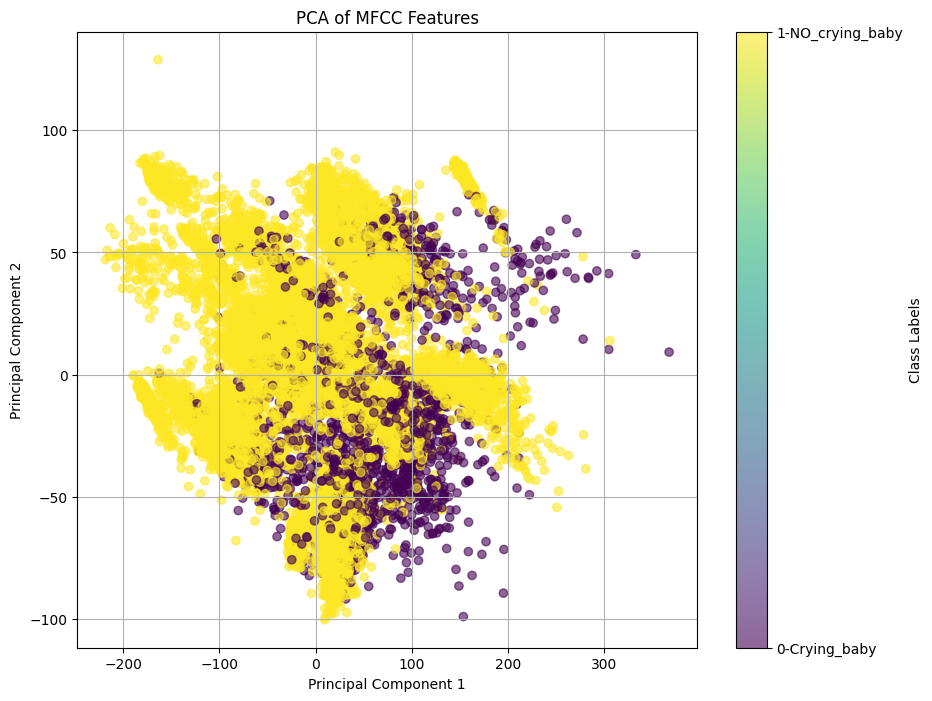

In [ ]:
# Plot MFCC features with PCA
display_PCA(features_mfcc, 'PCA of MFCC Features')

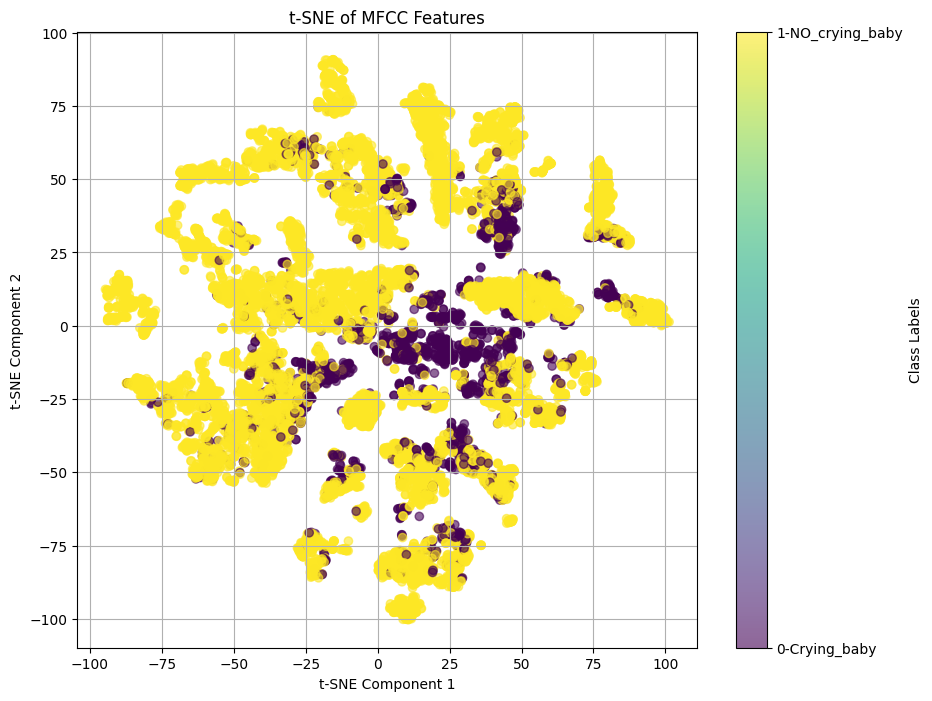

In [ ]:
# Plot MFCC features with t-SNE
display_tSNE(features_mfcc, 't-SNE of MFCC Features')

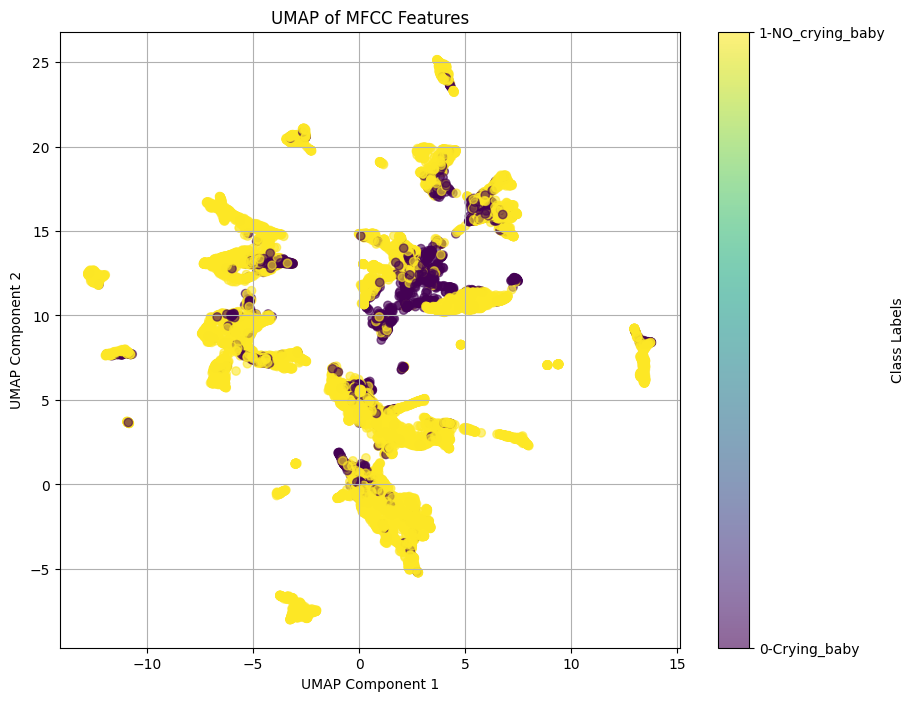

In [ ]:
# Plot MFCC features with UMAP
display_UMAP(features_mfcc, 'UMAP of MFCC Features')

## 5. Extract LPC features

In [10]:
def extract_lpc_features_per_second(file_name, n_lpc=10, sr=44100):
    '''
    Extracts LPC features for every second of an audio file.

    Input:
      - file_name: (str) Name of the audio file.
      - n_lpc: (int) Number of LPC coefficients to extract (default: 10).
      - sr: (int) Audio sampling rate (default: 44100 Hz).

    Output:
      - mfcc_list (list): List of LPC features per second.
    '''
    try:
        # Load the audio file and its sample rate
        audio, sample_rate = librosa.load(file_name, sr=sr)
        lpc_list = []
        buffer_length = sample_rate

        # Applying high-frequency emphasis to audio file
        emphasis_filter = np.array([1, -0.97])
        audio = scipy.signal.lfilter(emphasis_filter, 1, audio)

        # Iterate over the audio in 1-second segments
        for i in range(0, len(audio), buffer_length):
            end_i = min(i + buffer_length, len(audio))
            audio_segment = audio[i:end_i]

            # Make sure that the segment is of sufficient length (omits short segments )
            if len(audio_segment) < n_lpc:
                continue

            # Apply Hamming window
            window = get_window('hamming', len(audio_segment), False)
            audio_segment = audio_segment * window

            # Calculate the autocorrelation
            autocorr = np.correlate(audio_segment, audio_segment, mode='full')
            autocorr = autocorr[autocorr.size // 2:autocorr.size // 2 + n_lpc + 1]

            try:
                # Solving the Toeplitz equation for the LPC coefficients (using Levinson-Durbin)
                lpc_coef = solve_toeplitz((autocorr[:-1], autocorr[:-1]), -autocorr[1:])

            except LinAlgError:
                lpc_coef = np.zeros(n_lpc)

            lpc_list.append(lpc_coef)

    except Exception as e:
        print(f"Error encountered while parsing file: {file_name}, Error: {e}")
        return None

    return lpc_list

In [ ]:
# lists for storing LPC characteristics and labels
features_lpc = []
labels_lpc = []

for index, row in unclassified_data.iterrows():
    # Path of the audio file from which the features are to be extracted
    file_path = "drive/MyDrive/TFM/Audios/" + row['File_name']

    # Convert the string representing a list to a list of integers
    try:
        # Select only the values [0, 1], discarding commas or symbols inside the label vector
        labels_per_second = ast.literal_eval(row['Labels'])

    except ValueError:
        print(f"Error parsing labels for file {row['File_name']}")
        continue

    # Extract LPC features per second from the audio file
    lpcs_per_second = extract_lpc_features_per_second(file_path)

    if lpcs_per_second is not None:
        # Ensures that the length of the labels matches the extracted LPCs
        min_length = min(len(lpcs_per_second), len(labels_per_second))

        features_lpc.extend(lpcs_per_second[:min_length])
        labels_lpc.extend(labels_per_second[:min_length])
    else:
        print(f"Discrepancy in lengths for file {row['File_name']}")

# Convert to NumPy arrays for training
features_lpc = np.array(features_lpc)
labels_lpc = np.array(labels_lpc)

In [31]:
print("Length of LPC features:", len(features_lpc))
print("Length of labels:", len(labels_lpc))

Length of LPC features: 12399
Length of labels: 12399


In [ ]:
# Save the MFCC features and the labels
np.save('features_lpc_binary.npy', features_lpc)
np.save('labels_lpc_binary.npy', labels_lpc)

## 6. Plot LPC features

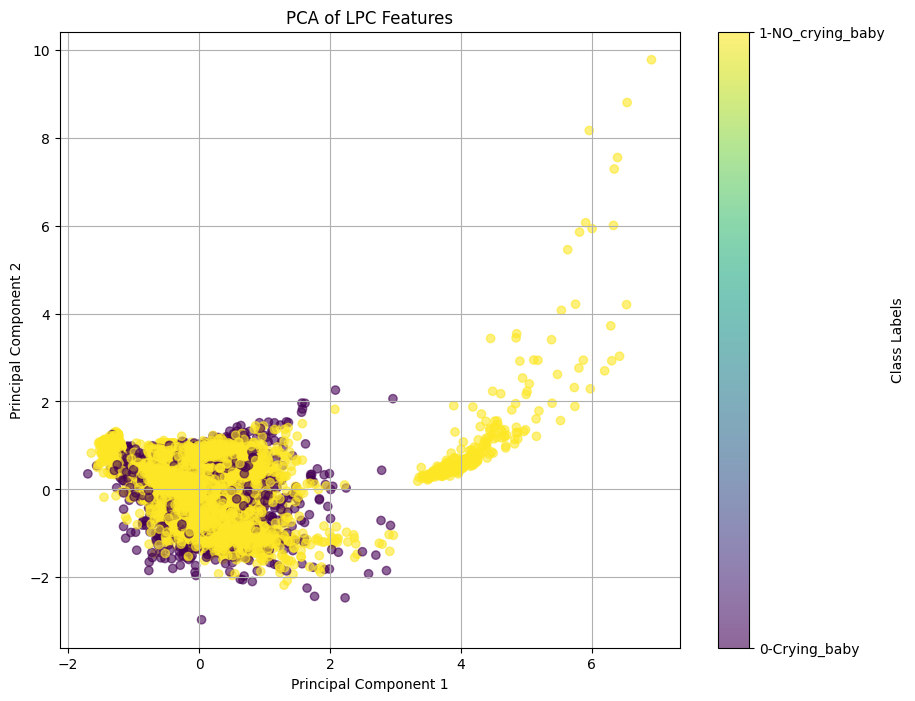

In [25]:
# Plot LPC features with PCA
display_PCA(features_lpc, labels_lpc, 'PCA of LPC Features')

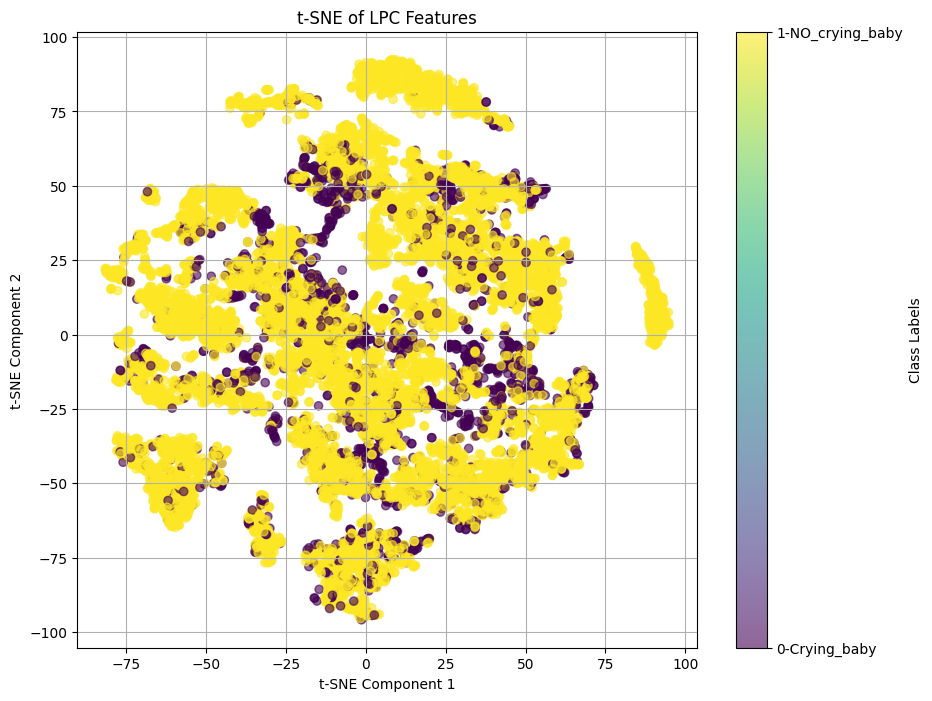

In [25]:
# Plot LPC features with t-SNE
display_tSNE(features_lpc, labels_lpc, 't-SNE of LPC Features')

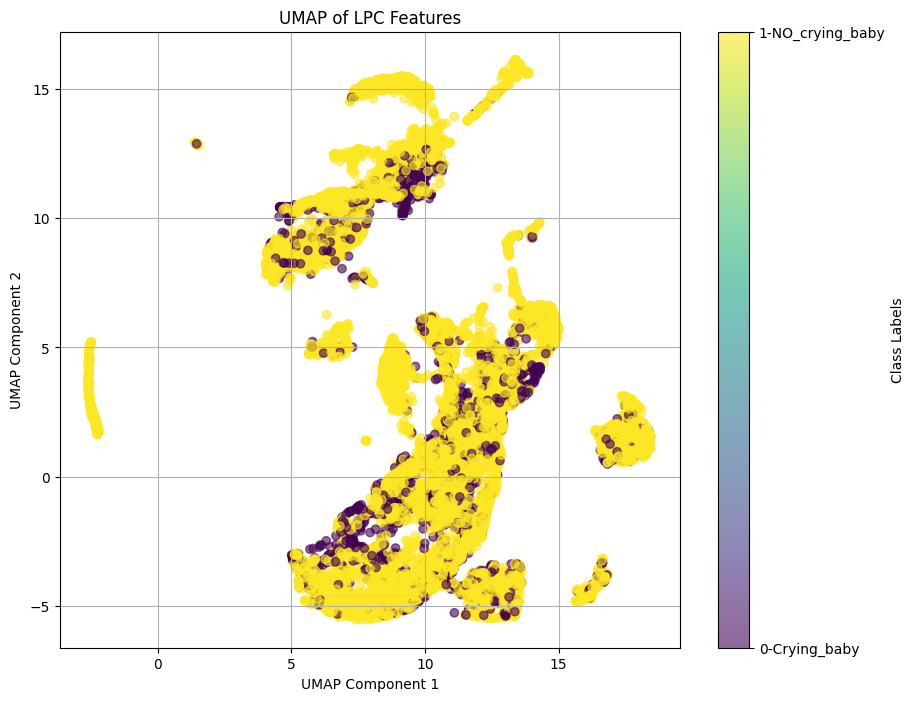

In [ ]:
# # Plot LPC features with UMAP
display_UMAP(features_lpc, labels_lpc, 'UMAP of LPC Features')